In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import model_from_yaml
from keras.callbacks import TensorBoard

import pandas as pd
import numpy as np
import os
import json

import common
from importlib import reload
%matplotlib inline


In [18]:
#
# Parameters
#
split = 7500
max_features = 6000
maxlen = 100
batch_size = 32
embedding_dims = 100
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 10


In [19]:
#
# Load the dataset
#
reload(common)

(train_sentences, train_categories, test_sentences, test_categories) = common.load_dataset('../dataset/redis_dataset.csv', split=0.7)
print(train_sentences.shape)

9849
(6894,)


In [20]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_sentences)
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

dictionary = tokenizer.word_index

print('Found %s unique tokens.' % len(dictionary))

# Let's save this out so we can use it later
with open('models/dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)


Found 5094 unique tokens.


In [ ]:
#
# Load Glove embeddings
#
glove_dir = '/Users/nscsekhar/Desktop/nscsekhar/Desktop/Surya/Personal/MIDS/W266/glove/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

#
# Get Embedding matrix
#
embedding_matrix = np.zeros((max_features, embedding_dims))
for word, i in dictionary.items():
    if i < max_features:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [5]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = sequence.pad_sequences(test_sequences, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (6894, 100)
x_test shape: (2955, 100)


In [23]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dims,
#                     weights=[embedding_matrix],
#                     trainable=False,
                    input_length=maxlen))

# model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.1))

# model.add(layers.Bidirectional(layers.LSTM(32)))

model.add(Dense(1, activation='sigmoid'))
# model.add(Dropout(0.1))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

tbCallback = TensorBoard(log_dir='./logs/rnn', histogram_freq=0,
                          write_graph=True, write_images=False)
metrics = common.Metrics()

history = model.fit(x_train, train_categories,
          batch_size=batch_size,
          epochs=5,
          validation_data=(x_test, test_categories),
          callbacks=[metrics, tbCallback])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          600000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 617,057
Trainable params: 617,057
Non-trainable params: 0
_________________________________________________________________
None
Train on 6894 samples, validate on 2955 samples
Epoch 1/5
6894/6894 [==============================] - 23s 3ms/step - loss: 0.5454 - acc: 0.7166 - val_loss: 0.4699 - val_acc: 0.7797
Epoch 2/5
6894/6894 [==============================] - 22s 3ms/step - loss: 0.363

Precision: 0.7508196721311475
Recall: 0.7298797409805735
F1: 0.7235213204951856


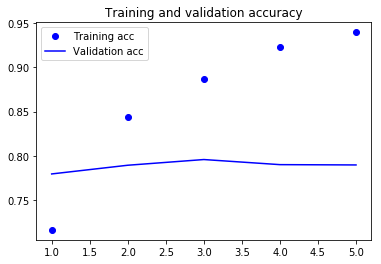

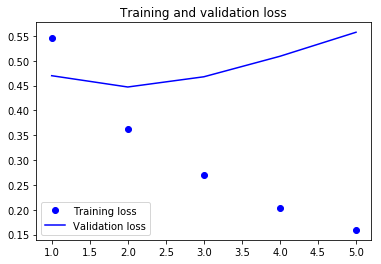

In [24]:
reload(common)
metrics.print_all()

common.plot_model_history(history)

In [25]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [26]:
#
# Save the model as a yaml
#
model_yaml = model.to_yaml()
with open("models/rnn_model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("models/rnn_model.h5")
print("Saved model to disk")


Saved model to disk


In [27]:
# load YAML and create model
yaml_file = open("models/rnn_model.yaml", 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()

loaded_model = model_from_yaml(loaded_model_yaml)

# load weights into new model
loaded_model.load_weights("models/rnn_model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, test_categories, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 78.98%


In [28]:
#
# Load a new source file
#
# reload(common)
test_file='/tmp/fe-connect.c'
comment_sents = []

#
# Get comment sentences
#
comment_sents += common.get_comment_sents(test_file)
# print(len(comment_sents))
# for sent in comment_sents:
#     print(sent)


In [33]:
#
# Predict the comment sentences
#
reload(common)
import json

pred_tokenizer = Tokenizer(num_words=max_features)
labels = ['Needs Fix', 'Good comment']
count_zero = count_one = 0

with open('models/dictionary.json', 'r') as dictionary_file:
    dictionary = json.load(dictionary_file)

for sent in comment_sents:
    print("Sentence: \n",sent)
    comment_sequence = common.convert_text_to_index_array(sent, dictionary)
    comment_vector = sequence.pad_sequences([comment_sequence], maxlen=maxlen)

    pred = loaded_model.predict_classes(comment_vector)
    print("Readability score: ", labels[int(pred)])
    if pred == 0:
        count_zero += 1
    else:
        count_one += 1
    

Sentence: 
  mstcpip.h is missing on mingw
Readability score:  Needs Fix
Sentence: 
  OpenLDAP deprecates RFC 1823, but we want standard conformance
Readability score:  Needs Fix
Sentence: 
   Pre-9.0 servers will return this SQLSTATE if asked to set  application_name in a startup packet.
Readability score:  Needs Fix
Sentence: 
 We hard-wire the value rather  than looking into errcodes.h since it reflects historical behavior  rather than that of the current code.
Readability score:  Good comment
Sentence: 
  This is part of the protocol so just define it
Readability score:  Needs Fix
Sentence: 
  This too
Readability score:  Needs Fix
Sentence: 
   Cope with the various platform-specific ways to spell TCP keepalive socket  options.
Readability score:  Good comment
Sentence: 
 This doesn't cover Windows, which as usual does its own thing.
Readability score:  Good comment
Sentence: 
  TCP_KEEPIDLE is the name of this option on Linux and BSD
Readability score:  Needs Fix
Sentence: 
  TCP

Readability score:  Needs Fix
Sentence: 
  PQping   check server status, accepting parameters identical to PQconnectdb
Readability score:  Needs Fix
Sentence: 
  PQconnectStartParams   Begins the establishment of a connection to a postgres backend through the  postmaster using connection information in a struct.
Readability score:  Needs Fix
Sentence: 
 See comment for PQconnectdbParams for the definition of the string format.
Readability score:  Needs Fix
Sentence: 
 Returns a PGconn.
Readability score:  Needs Fix
Sentence: 
 If NULL is returned, a malloc error has occurred, and  you should not attempt to proceed with this connection.
Readability score:  Needs Fix
Sentence: 
 If the status  field of the connection returned is CONNECTION_BAD, an error has  occurred.
Readability score:  Needs Fix
Sentence: 
 In this case you should call PQfinish on the result, (perhaps  inspecting the error message first).
Readability score:  Needs Fix
Sentence: 
 Other fields of the structure may not  

Readability score:  Needs Fix
Sentence: 
 Pre-7.0 applications that use this function will see a small memory leak  until they are updated to call PQconninfoFree.
Readability score:  Needs Fix
Sentence: 
  We don't actually report any errors here, but callees want a buffer
Readability score:  Good comment
Sentence: 
  out of memory already :-(
Readability score:  Needs Fix
Sentence: 
  pass NULL errorBuf to ignore errors
Readability score:  Needs Fix
Sentence: 
  ---------------- PQsetdbLogin   establishes a connection to a postgres backend through the postmaster  at the specified host and port.
Readability score:  Needs Fix
Sentence: 
 returns a PGconn which is needed for all subsequent libpq calls   if the status field of the connection returned is CONNECTION_BAD,  then only the errorMessage is likely to be useful.
Readability score:  Good comment
Sentence: 
   Allocate memory for the conn structure
Readability score:  Needs Fix
Sentence: 
   If the dbName parameter contains what loo

Readability score:  Good comment
Sentence: 
  F_SETFD
Readability score:  Needs Fix
Sentence: 
  Do nothing
Readability score:  Needs Fix
Sentence: 
  WIN32
Readability score:  Needs Fix
Sentence: 
  SIO_KEEPALIVE_VALS
Readability score:  Needs Fix
Sentence: 
  WIN32
Readability score:  Needs Fix
Sentence: 
 ----------  We have three methods of blocking SIGPIPE during  send() calls to this socket:  - setsockopt(sock, SO_NOSIGPIPE) - send(sock, ..., MSG_NOSIGNAL) - setting the signal mask to SIG_IGN during send()   The third method requires three syscalls per send,  so we prefer either of the first two, but they are  less portable.
Readability score:  Good comment
Sentence: 
 The state is tracked in the following  members of PGconn:   conn->sigpipe_so- we have set up SO_NOSIGPIPE  conn->sigpipe_flag- we're specifying MSG_NOSIGNAL   If we can use SO_NOSIGPIPE, then set sigpipe_so here  and we're done.
Readability score:  Needs Fix
Sentence: 
 Otherwise, set sigpipe_flag so that  we will 

Readability score:  Needs Fix
Sentence: 
  reread data
Readability score:  Needs Fix
Sentence: 
  We'll come back when there is more data
Readability score:  Good comment
Sentence: 
  OK, we read the message; mark data consumed
Readability score:  Needs Fix
Sentence: 
   The postmaster typically won't end its message with a  newline, so add one to conform to libpq conventions.
Readability score:  Needs Fix
Sentence: 
   If we tried to open the connection in 3.0 protocol,  fall back to 2.0 protocol.
Readability score:  Needs Fix
Sentence: 
  Must drop the old connection
Readability score:  Needs Fix
Sentence: 
   Can't process if message body isn't all here yet.
Readability score:  Needs Fix
Sentence: 
 (In protocol 2.0 case, we are assuming messages carry at  least 4 bytes of data.)
Readability score:  Needs Fix
Sentence: 
   Before returning, try to enlarge the input buffer if  needed to hold the whole message; see notes in  pqParseInput3.
Readability score:  Needs Fix
Sentence: 
  We

Readability score:  Good comment
Sentence: 
 We do not want  to report that the server is not up just because we didn't have a valid  password, for example.
Readability score:  Needs Fix
Sentence: 
 In fact, any sort of authentication request  implies the server is up.
Readability score:  Needs Fix
Sentence: 
 (We need this check since the libpq side of  things might have pulled the plug on the connection before getting an  error as such from the postmaster.)
Readability score:  Needs Fix
Sentence: 
   If we failed to get any ERROR response from the postmaster, report  PQPING_NO_RESPONSE.
Readability score:  Needs Fix
Sentence: 
 This result could be somewhat misleading for a  pre-7.4 server, since it won't send back a SQLSTATE, but those are long  out of support.
Readability score:  Needs Fix
Sentence: 
 Another corner case where the server could return a  failure without a SQLSTATE is fork failure, but NO_RESPONSE isn't  totally unreasonable for that anyway.
Readability score:  Needs

Readability score:  Needs Fix
Sentence: 
 Note we don't actually expect this  read to obtain any data, we are just waiting for EOF to be signaled.
Readability score:  Good comment
Sentence: 
  Interrupted system call - we'll just try again
Readability score:  Good comment
Sentence: 
  we ignore other error conditions
Readability score:  Needs Fix
Sentence: 
  All done
Readability score:  Needs Fix
Sentence: 
   Make sure we don't overflow the error buffer.
Readability score:  Good comment
Sentence: 
 Leave space for the \n at  the end, and for the terminating zero.
Readability score:  Needs Fix
Sentence: 
   PQcancel: request query cancel   Returns true if able to send the cancel request, false if not.
Readability score:  Good comment
Sentence: 
 On failure, an error message is stored in errbuf, which must be of size  errbufsize (recommended size is 256 bytes).
Readability score:  Needs Fix
Sentence: 
 errbuf is not changed on  success return.
Readability score:  Good comment
Sentence:

Readability score:  Needs Fix
Sentence: 
   Build a working copy of the constant PQconninfoOptions array.
Readability score:  Needs Fix
Sentence: 
   Get enough memory for all options in PQconninfoOptions, even if some  end up being filtered out.
Readability score:  Needs Fix
Sentence: 
  Only copy the public part of the struct, not the full internal
Readability score:  Good comment
Sentence: 
   Connection string parser   Returns a malloc'd PQconninfoOption array, if parsing is successful.
Readability score:  Needs Fix
Sentence: 
 Otherwise, NULL is returned and an error message is left in errorMessage.
Readability score:  Needs Fix
Sentence: 
 If use_defaults is true, default values are filled in (from a service file,  environment variables, etc).
Readability score:  Needs Fix
Sentence: 
  Parse as URI if connection string matches URI prefix
Readability score:  Needs Fix
Sentence: 
  Parse as default otherwise
Readability score:  Needs Fix
Sentence: 
   Checks if connection string st

Readability score:  Needs Fix
Sentence: 
  Save last char and cut off at end of user name
Readability score:  Needs Fix
Sentence: 
  Advance past end of parsed user name or password token
Readability score:  Needs Fix
Sentence: 
   No username or password designator found.
Readability score:  Needs Fix
Sentence: 
 Reset to start of URI.
Readability score:  Needs Fix
Sentence: 
   There may be multiple netloc[:port] pairs, each separated from the next  by a comma.
Readability score:  Good comment
Sentence: 
 When we initially enter this loop, "p" has been  incremented past optional URI credential information at this point and  now points at the "netloc" part of the URI.
Readability score:  Needs Fix
Sentence: 
 On subsequent loop  iterations, "p" has been incremented past the comma separator and now  points at the start of the next "netloc".
Readability score:  Needs Fix
Sentence: 
   Look for IPv6 address.
Readability score:  Needs Fix
Sentence: 
  Cut off the bracket and advance
Reada

Readability score:  Needs Fix
Sentence: 
 In protocol 3 and up we can rely on the  backend to report the parameter value, and we'll change state at  that time.
Readability score:  Good comment
Sentence: 
  everything is ok
Readability score:  Needs Fix
Sentence: 
   The default notice message receiver just gets the standard notice text  and sends it to the notice processor.
Readability score:  Good comment
Sentence: 
 This two-level setup exists  mostly for backwards compatibility; perhaps we should deprecate use of  PQsetNoticeProcessor?
Readability score:  Needs Fix
Sentence: 
  not used
Readability score:  Needs Fix
Sentence: 
   The default notice message processor just prints the  message on stderr.
Readability score:  Good comment
Sentence: 
 Applications can override this if they  want the messages to go elsewhere (a window, for example).
Readability score:  Good comment
Sentence: 
 Note that simply discarding notices is probably a bad idea.
Readability score:  Good comment
Sent

In [32]:
print("Comments Needing Fix:", count_zero)
print("Good Comments:", count_one)

Comments Needing Fix: 543
Good Comments: 243
